In [3]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split

# Define paths
DATASET_DIR = '/home/user/cnn/data'
CATEGORIES = ['met', 'nichtmet']
IMG_SIZE = 640  # Ensure your system has enough memory for this size
NEW_MODEL_PATH = '/home/user/cnn/model/metal_classifier_model_mobile.keras'
RESULTS_DIR = '/home/user/cnn/results_' + datetime.now().strftime('%Y%m%d_%H%M%S')

os.makedirs(RESULTS_DIR, exist_ok=True)

# Load and preprocess new dataset
def load_data(dataset_dir, categories, img_size):
    data = []
    for category in categories:
        path = os.path.join(dataset_dir, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                img_array = cv2.imread(img_path)
                img_array = cv2.resize(img_array, (img_size, img_size))
                data.append([img_array, class_num])
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    return data

data = load_data(DATASET_DIR, CATEGORIES, IMG_SIZE)
np.random.shuffle(data)

X = np.array([item[0] for item in data]) / 255.0
y = np.array([item[1] for item in data])

y = tf.keras.utils.to_categorical(y, num_classes=len(CATEGORIES))

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

# Load MobileNetV2 pre-trained model
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                               include_top=False,
                                               weights='imagenet')

# Freeze the base model
base_model.trainable = False

# Add custom layers on top of base model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(CATEGORIES), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint(os.path.join(RESULTS_DIR, 'best_model.keras'), save_best_only=True, monitor='val_loss', mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Reduce the batch size if you encounter memory issues
batch_size = 16

# Train the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                    epochs=100,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, checkpoint, reduce_lr])

# Load the best model
model.load_weights(os.path.join(RESULTS_DIR, 'best_model.keras'))

# Fine-tune the model (unfreeze some layers)
base_model.trainable = True

# Recompile the model
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # Low learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Continue training
history_finetune = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                             epochs=100,
                             validation_data=(X_val, y_val),
                             callbacks=[early_stopping, checkpoint, reduce_lr])

# Save the final model
model.save(NEW_MODEL_PATH)

# Save training information
def save_training_info(history, results_dir, phase="initial"):
    # Plot training & validation accuracy and loss
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Model Accuracy ({phase} phase)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig(os.path.join(results_dir, f'{phase}_accuracy_plot.png'))

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Model Loss ({phase} phase)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig(os.path.join(results_dir, f'{phase}_loss_plot.png'))

    # Save history as text
    with open(os.path.join(results_dir, f'{phase}_training_history.txt'), 'w') as f:
        f.write(str(history.history))

save_training_info(history, RESULTS_DIR, phase="initial")
save_training_info(history_finetune, RESULTS_DIR, phase="finetune")

print(f"New model saved to {NEW_MODEL_PATH}")
print(f"Training information saved to {RESULTS_DIR}")


: 

## Additional Code for Test Data Evaluation and Deployment:

## 1. Evaluate Model on Test Data:

In [11]:
# Load test data
# Note: Load test data here from another folder
TEST_DIR = 'F:\\Study\\TU Dortmund\\Industrial Data Science 2\\Code\\Reference\\CNN\\train'
test_data = load_data(TEST_DIR, CATEGORIES, IMG_SIZE)

X_test = np.array([item[0] for item in test_data]) / 255.0
y_test = np.array([item[1] for item in test_data])

y_test = tf.keras.utils.to_categorical(y_test, num_classes=len(CATEGORIES))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.9486 - loss: 0.1352
Test Accuracy: 94.09%
Test Loss: 0.1577


## 2. Convert Model for Mobile Deployment:

In [13]:
# Convert Keras model to SavedModel format
model.save('F:\Study\TU Dortmund\Industrial Data Science 2\Code\Reference\CNN\results_20240702_155253\best_model.keras')

# Convert SavedModel to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model')
tflite_model = converter.convert()

TFLITE_MODEL_PATH = 'metal_classifier_model_mobile.tflite'
with open(TFLITE_MODEL_PATH, 'wb') as f:
    f.write(tflite_model)

print(f"Model converted and saved to {TFLITE_MODEL_PATH}")


ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=saved_model.

In [12]:
import tensorflow as tf

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model
TFLITE_MODEL_PATH = 'F:\\Study\\TU Dortmund\\Industrial Data Science 2\\Code\\Reference\\CNN\\metal_classifier_model_mobile.tflite'
with open(TFLITE_MODEL_PATH, 'wb') as f:
    f.write(tflite_model)

print(f"Model converted and saved to {TFLITE_MODEL_PATH}")


AttributeError: 'Sequential' object has no attribute '_get_save_spec'

## 3. Load and Test the TensorFlow Lite Model:

In [10]:
# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path=TFLITE_MODEL_PATH)
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Prepare input data
input_data = np.expand_dims(X_test[0], axis=0).astype(np.float32)  # Example with the first test image

# Set the tensor to point to the input data to be inferred
interpreter.set_tensor(input_details[0]['index'], input_data)

# Run the inference
interpreter.invoke()

# Get the results
output_data = interpreter.get_tensor(output_details[0]['index'])
predicted_label = np.argmax(output_data)
print(f"Predicted label: {CATEGORIES[predicted_label]}")


NameError: name 'TFLITE_MODEL_PATH' is not defined

## More improved enhanancements

2024-07-18 05:30:19.510138: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-18 05:30:19.857306: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-18 05:30:19.964542: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-18 05:30:19.996887: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-18 05:30:20.213884: I tensorflow/core/platform/cpu_feature_guar

Epoch 1/50


/home/user/cnn/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1721273442.663879    6456 service.cc:146] XLA service 0x7fc428004d80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721273442.663946    6456 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2024-07-18 05:30:43.144576: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-18 05:30:44.853454: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


1/8 ━━━━━━━━━━━━━━━━━━━━ 4:00 34s/step - accuracy: 0.5000 - loss: 0.6931

I0000 00:00:1721273463.383934    6456 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-07-18 05:31:07.803807: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_14552', 148 bytes spill stores, 148 bytes spill loads

2024-07-18 05:31:08.034425: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_14552', 336 bytes spill stores, 336 bytes spill loads

2024-07-18 05:31:08.914812: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_14552', 124 bytes spill stores, 124 bytes spill loads

2024-07-18 05:31:09.308288: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are 

7/8 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/step - accuracy: 0.5319 - loss: 0.8751 

2024-07-18 05:31:29.742484: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1196', 148 bytes spill stores, 148 bytes spill loads

2024-07-18 05:31:34.537432: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1214', 4 bytes spill stores, 4 bytes spill loads

2024-07-18 05:31:34.784600: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1196', 12 bytes spill stores, 12 bytes spill loads

2024-07-18 05:31:34.979488: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1196', 192 bytes spill stores, 192 bytes spill loads



8/8 ━━━━━━━━━━━━━━━━━━━━ 70s 5s/step - accuracy: 0.5316 - loss: 0.8750 - val_accuracy: 0.5000 - val_loss: 1.3094
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.5233 - loss: 0.7390 - val_accuracy: 0.5000 - val_loss: 2.5675
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.5451 - loss: 0.7050 - val_accuracy: 0.5000 - val_loss: 6.8526
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.5204 - loss: 0.7124 - val_accuracy: 0.5000 - val_loss: 8.5695
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.4813 - loss: 0.7017 - val_accuracy: 0.5000 - val_loss: 8.4567
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.4768 - loss: 0.7354 - val_accuracy: 0.5000 - val_loss: 7.3134
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.4986 - loss: 0.7458 - val_accuracy: 0.5000 - val_loss: 14.7325
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.5601 - loss: 0.7847 - val_accuracy: 0.5000 - val_loss: 15.7362
Epoch 9/50

/home/user/cnn/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/user/cnn/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/user/cnn/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


New model saved to /home/user/cnn/model/metal_classifier_model_mobile.keras
Training information saved to results_20240718_053023


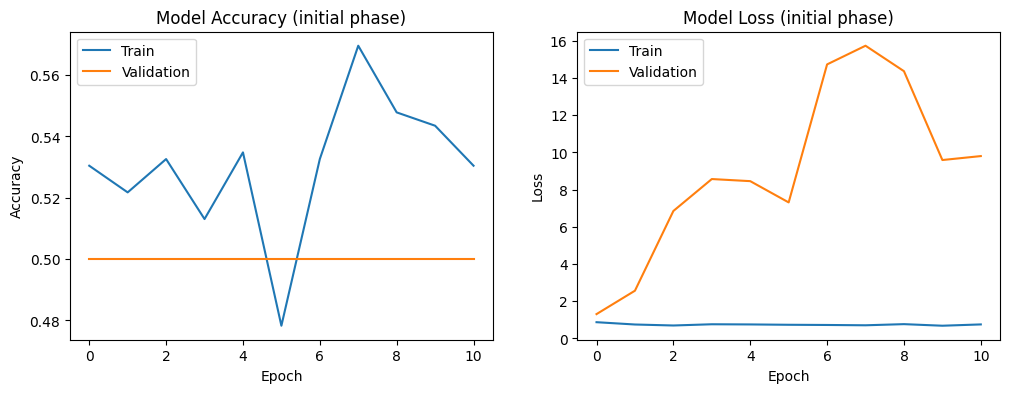

In [1]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Define paths
DATASET_DIR = '/home/user/cnn/data'
CATEGORIES = ['met', 'nichtmet']
IMG_SIZE = 128
NEW_MODEL_PATH = '/home/user/cnn/model/metal_classifier_model_mobile.keras'
RESULTS_DIR = 'results_' + datetime.now().strftime('%Y%m%d_%H%M%S')

os.makedirs(RESULTS_DIR, exist_ok=True)

# Load and preprocess new dataset
def load_data(dataset_dir, categories, img_size):
    data = []
    for category in categories:
        path = os.path.join(dataset_dir, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                img_array = cv2.imread(img_path)
                img_array = cv2.resize(img_array, (img_size, img_size))
                data.append([img_array, class_num])
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    return data

data = load_data(DATASET_DIR, CATEGORIES, IMG_SIZE)
np.random.shuffle(data)

X = np.array([item[0] for item in data]) / 255.0
y = np.array([item[1] for item in data])

y = tf.keras.utils.to_categorical(y, num_classes=len(CATEGORIES))

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

# Load MobileNetV2 pre-trained model
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                               include_top=False,
                                               weights='imagenet')

# Add custom layers on top of base model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(len(CATEGORIES), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint(os.path.join(RESULTS_DIR, 'best_model.keras'), save_best_only=True, monitor='val_loss', mode='min')

# Train the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=64),
                    epochs=50,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, checkpoint])

# Evaluate on validation set
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
print(f'Final Validation Loss: {val_loss:.4f}, Final Validation Accuracy: {val_acc:.4f}')

# Print classification report
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)
print(classification_report(y_true, y_pred_classes, target_names=CATEGORIES))

# Save the final model
model.save(NEW_MODEL_PATH)

# Save training information
def save_training_info(history, results_dir, phase="initial"):
    # Plot training & validation accuracy and loss
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Model Accuracy ({phase} phase)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig(os.path.join(results_dir, f'{phase}_accuracy_plot.png'))

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Model Loss ({phase} phase)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig(os.path.join(results_dir, f'{phase}_loss_plot.png'))

    # Save history as text
    with open(os.path.join(results_dir, f'{phase}_training_history.txt'), 'w') as f:
        f.write(str(history.history))

save_training_info(history, RESULTS_DIR, phase="initial")

print(f"New model saved to {NEW_MODEL_PATH}")
print(f"Training information saved to {RESULTS_DIR}")


In [ ]:
# Evaluation metrics
from sklearn.metrics import classification_report

# Load the best model for evaluation
model = tf.keras.models.load_model('F:\\Study\\TU Dortmund\\Industrial Data Science 2\\Code\\Reference\\CNN\\results_20240702_163204\\best_model.keras')

# Evaluate on validation set
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

# Get predictions for confusion matrix and classification report
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

# Print classification report
print(classification_report(y_true, y_pred_classes, target_names=CATEGORIES))


Validation Loss: 1.2944, Validation Accuracy: 0.4394
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 234ms/step
              precision    recall  f1-score   support

         met       0.44      1.00      0.61        58
    nichtmet       0.00      0.00      0.00        74

    accuracy                           0.44       132
   macro avg       0.22      0.50      0.31       132
weighted avg       0.19      0.44      0.27       132



f:\Study\TU Dortmund\Industrial Data Science 2\Code\Reference\CNN\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
f:\Study\TU Dortmund\Industrial Data Science 2\Code\Reference\CNN\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
f:\Study\TU Dortmund\Industrial Data Science 2\Code\Reference\CNN\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` paramete

In [26]:
# Evaluate on validation set
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
print(f'Final Validation Loss: {val_loss:.4f}, Final Validation Accuracy: {val_acc:.4f}')

# Print classification report
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)
print(classification_report(y_true, y_pred_classes, target_names=CATEGORIES))


Final Validation Loss: 1.3257, Final Validation Accuracy: 0.4394
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 242ms/step
              precision    recall  f1-score   support

         met       0.44      1.00      0.61        58
    nichtmet       0.00      0.00      0.00        74

    accuracy                           0.44       132
   macro avg       0.22      0.50      0.31       132
weighted avg       0.19      0.44      0.27       132



f:\Study\TU Dortmund\Industrial Data Science 2\Code\Reference\CNN\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
f:\Study\TU Dortmund\Industrial Data Science 2\Code\Reference\CNN\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
f:\Study\TU Dortmund\Industrial Data Science 2\Code\Reference\CNN\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` paramete

### Train new for mobile images 

In [1]:
import os
import numpy as np
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, precision_recall_curve, average_precision_score

# Enable mixed precision
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Define paths
DATASET_DIR = '/home/user/unet/cnn/data'
CATEGORIES = ['met', 'nichtmet']
IMG_SIZE = 512  # Reduced image size

# Function to load and preprocess the images
def load_data():
    data = []
    for category in CATEGORIES:
        path = os.path.join(DATASET_DIR, category)
        class_num = CATEGORIES.index(category)
        for img in tqdm(os.listdir(path)):
            try:
                img_path = os.path.join(path, img)
                img_array = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([img_array, class_num])
            except Exception as e:
                pass
    return data

# Load and shuffle data
data = load_data()
np.random.shuffle(data)

# Split data into features (X) and labels (y)
X = np.array([item[0] for item in data]).reshape(-1, IMG_SIZE, IMG_SIZE, 1) / 255.0
y = np.array([item[1] for item in data])

# One-hot encode the labels
y = to_categorical(y, num_classes=len(CATEGORIES))

# Split data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Fit the data generator to the training data
datagen.fit(X_train)

# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(len(CATEGORIES), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Model checkpoint callback
checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')

# Reduce learning rate callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-4)

# Train the model with batch size 2
history = model.fit(datagen.flow(X_train, y_train, batch_size=2),
                    epochs=100,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, checkpoint, reduce_lr])

# Load the best model
model.load_weights('best_model.keras')

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Predict on test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification report
report = classification_report(y_true_classes, y_pred_classes, target_names=CATEGORIES)
print(report)

# Precision and recall graph
precision = dict()
recall = dict()
average_precision = dict()
for i in range(len(CATEGORIES)):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_pred[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_pred[:, i])

plt.figure()
for i in range(len(CATEGORIES)):
    plt.plot(recall[i], precision[i], lw=2, label=f'Precision-recall curve of class {CATEGORIES[i]} (AP={average_precision[i]:0.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Save the model
model.save('metal_classifier_model_mobile_from_scratch.keras')
print("Model saved to metal_classifier_model_mobile_from_scratch.keras")


2024-07-18 10:08:47.184113: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-18 10:08:47.535168: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-18 10:08:47.649794: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-18 10:08:47.681543: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-18 10:08:47.908342: I tensorflow/core/platform/cpu_feature_guar

Epoch 1/100


/home/user/unet/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1721290138.160726   26640 service.cc:146] XLA service 0x7f30b4006ec0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721290138.160779   26640 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2024-07-18 10:08:58.244358: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-18 10:08:58.603588: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
I000

230/231 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5700 - loss: 2.3377

2024-07-18 10:09:12.628148: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_126', 164 bytes spill stores, 164 bytes spill loads

